- 삼성전자 주식 다음달 가격이 얼마일까?(회귀)
- 비트코인 다음 달 어떻게 될까?(회귀)
- 전날 비트 코인 상승하면 다음날 주가와의 상관관계(correlation)

1. 목표 설정
   1. Y : 미래의 30일의 국내 특정주식과 비트코인의 종가
   1. X : 최근 60일간의 데이터
      1. step : 하루 간격
      1. 양 : x 년치(1년치 : 2018년 6월 ~ 2019년 6월)
1. 데이터 획득
   1. 국내 기업 1개, 비트코인
1. 두 데이터 날짜 기준으로 통합(axis=1)
      1. 외국 날짜타입(2018-01-01), 국내(2018.1.1),(18.1.1)
      1. 날짜 포맷을 (YYYY-MM-DD) 으로 변환 후 통합  
1. 데이터 정제
   1. 누락
1. 데이터 전처리
   1. 특수기호, 문자를 수치로 변환       
1. 비트코인 가격 변화와 주가와의 상관관계(correlation)
   1. cov() 사용하면 상관관계가 나옴
1. 입력 X / 출력 Y 분리
   1. m개의 x, y 쌍 ( m은 샘플 갯수 )
   1. x(m, 60, 10-15)(국내증시컬럼 + 비트코인컬럼) -> reshape -> (m, 60 * 15)
   1. y(m, 30, 2) == (m, 30 * 2)
1. 학습용/검증용(test) 분리
   1. 섞으면 안되므로 직접 분리
   1. 과거 데이터 10% 를 검증용으로 사용
1. 모델 선정
   1. Ridge 모델,  학습용 데이터로 학습
   1. 성능 측정
1. 그래프로 시각화
   1. 과거 데이타
   1. 미래의 예측 predict(x(1, 60 * 15) ) -> return -> y_hat(1, 30 * 2)
      1. 미래 예측(1, 30 * 2) -> (30,2) ->  국내주식(30), 비트코인(30) -> 그래프로 그리기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
samsung_url='https://finance.naver.com/item/sise_day.nhn?code=005930'

In [3]:
# 기본 정보 확인
tables = pd.read_html(samsung_url+'&page='+str('1'))
len(tables)
tables[0].head(3)

,날짜,종가,전일비,시가,고가,저가,거래량
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019.07.03,45550.0,700.0,45750.0,46350.0,45450.0,5151030.0
2,2019.07.02,46250.0,350.0,46200.0,46900.0,45850.0,8463073.0


In [125]:
samsungs = []
for i in range(1,27):
    tables = pd.read_html(samsung_url+'&page='+str(i))
    samsung = tables[0]
    samsungs.append(samsung)
len(samsungs)

26

In [126]:
samsung = pd.concat(samsungs, axis=0)
samsung.shape

(390, 7)

In [127]:
bitcoin_url='https://coinmarketcap.com/currencies/bitcoin/historical-data/'
bitcoin_url+='?start=20170601&end=20190701'
tables = pd.read_html(bitcoin_url)
bitcoin = tables[0]
bitcoin.head(3)

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,"Jul 01, 2019",10796.93,11206.44,10089.31,10583.13,29378589324,188297637574
1,"Jun 30, 2019",11931.99,12178.38,10799.01,10817.16,27256473494,192442065810
2,"Jun 29, 2019",12400.76,12400.91,11508.38,11959.37,29923961128,212739713110


# 데이터 통합
- 두 데이터 날짜 기준으로 통합(axis=1)
- 외국 날짜타입(2018-01-01), 국내(2018.1.1),(18.1.1)
- 날짜 포맷을 (YYYY-MM-DD) 으로 변환 후 통합  

In [128]:
samsung.shape, bitcoin.shape

((390, 7), (761, 7))

In [129]:
# 날짜를 인덱스로 변환 하여 맞추기
samsung = samsung.set_index('날짜')

In [130]:
bitcoin = bitcoin.set_index('Date')

In [131]:
samsung.index

Index([         nan, '2019.07.03', '2019.07.02', '2019.07.01', '2019.06.28',
       '2019.06.27',          nan,          nan,          nan, '2019.06.26',
       ...
       '2018.06.20',          nan,          nan,          nan, '2018.06.19',
       '2018.06.18', '2018.06.15', '2018.06.14', '2018.06.12',          nan],
      dtype='object', name='날짜', length=390)

In [132]:
bitcoin.index

Index(['Jul 01, 2019', 'Jun 30, 2019', 'Jun 29, 2019', 'Jun 28, 2019',
       'Jun 27, 2019', 'Jun 26, 2019', 'Jun 25, 2019', 'Jun 24, 2019',
       'Jun 23, 2019', 'Jun 22, 2019',
       ...
       'Jun 10, 2017', 'Jun 09, 2017', 'Jun 08, 2017', 'Jun 07, 2017',
       'Jun 06, 2017', 'Jun 05, 2017', 'Jun 04, 2017', 'Jun 03, 2017',
       'Jun 02, 2017', 'Jun 01, 2017'],
      dtype='object', name='Date', length=761)

In [133]:
# 인덱스를 날짜 타입으로 바꾸기
bitcoin.index = pd.to_datetime(bitcoin.index)
samsung.index = pd.to_datetime(samsung.index)

In [134]:
bitcoin.index

DatetimeIndex(['2019-07-01', '2019-06-30', '2019-06-29', '2019-06-28',
               '2019-06-27', '2019-06-26', '2019-06-25', '2019-06-24',
               '2019-06-23', '2019-06-22',
               ...
               '2017-06-10', '2017-06-09', '2017-06-08', '2017-06-07',
               '2017-06-06', '2017-06-05', '2017-06-04', '2017-06-03',
               '2017-06-02', '2017-06-01'],
              dtype='datetime64[ns]', name='Date', length=761, freq=None)

In [135]:
samsung.index

DatetimeIndex([       'NaT', '2019-07-03', '2019-07-02', '2019-07-01',
               '2019-06-28', '2019-06-27',        'NaT',        'NaT',
                      'NaT', '2019-06-26',
               ...
               '2018-06-20',        'NaT',        'NaT',        'NaT',
               '2018-06-19', '2018-06-18', '2018-06-15', '2018-06-14',
               '2018-06-12',        'NaT'],
              dtype='datetime64[ns]', name='날짜', length=390, freq=None)

In [136]:
# 통합 :  삼성과 비트코인을 열로 붙이기 
df = pd.concat((samsung, bitcoin), axis=1).dropna()
df.shape

(258, 12)

In [137]:
df.dtypes

종가            float64
전일비           float64
시가            float64
고가            float64
저가            float64
거래량           float64
Open*         float64
High          float64
Low           float64
Close**       float64
Volume        float64
Market Cap    float64
dtype: object

In [138]:
df.describe()  # 데이타의 통계 정보를 보여줌 => 제대로 보여주면 data에 이상 없음.

,종가,전일비,시가,고가,저가,거래량,Open*,High,Low,Close**,Volume,Market Cap
count,258.000000,258.000000,258.000000,258.000000,258.000000,2.580000e+02,258.000000,258.000000,258.000000,258.000000,2.580000e+02,2.580000e+02
mean,44431.395349,517.441860,44418.217054,44854.651163,43969.379845,1.117718e+07,5846.906860,5980.950620,5721.996357,5856.674651,9.321583e+09,1.021469e+11
std,2382.491827,441.528613,2430.824571,2377.046052,2380.480039,3.879109e+06,1818.040067,1908.624114,1747.318151,1844.164278,7.562480e+09,3.248507e+10
min,37450.000000,0.000000,37450.000000,37600.000000,36850.000000,4.762460e+06,3253.120000,3329.560000,3206.540000,3242.480000,3.230550e+09,5.649438e+10
25%,43112.500000,200.000000,43087.500000,43800.000000,42500.000000,8.264758e+06,4000.277500,4069.190000,3928.195000,3988.765000,4.378805e+09,6.997451e+10
50%,44850.000000,400.000000,44800.000000,45275.000000,44375.000000,1.067809e+07,6297.650000,6373.265000,6200.290000,6265.410000,5.591477e+09,1.084090e+11
75%,46237.500000,750.000000,46337.500000,46750.000000,45900.000000,1.289709e+07,6739.540000,6815.327500,6574.872500,6733.550000,1.080033e+10,1.155321e+11
max,49400.000000,2200.000000,49700.000000,49800.000000,49250.000000,2.625465e+07,13017.120000,13796.490000,11755.600000,13016.230000,4.510573e+10,2.314621e+11


In [139]:
df.isna().sum().sum()  # 데이타에 null이 몇개 있는지를 확인

0

In [140]:
df.cov()  # 상관관계를 보여줌

,종가,전일비,시가,고가,저가,거래량,Open*,High,Low,Close**,Volume,Market Cap
종가,5.676267e+06,-1.566646e+04,5.636459e+06,5.600145e+06,5.607473e+06,-1.863217e+09,1.401916e+06,1.436798e+06,1.389545e+06,1.433289e+06,-2.091046e+11,2.420745e+13
전일비,-1.566646e+04,1.949475e+05,-1.230341e+04,2.553140e+04,-5.045607e+04,8.494671e+08,-4.429880e+04,-5.598956e+04,-4.969676e+04,-6.219103e+04,-2.841456e+11,-1.131278e+12
시가,5.636459e+06,-1.230341e+04,5.908908e+06,5.710557e+06,5.724422e+06,-1.645382e+09,1.389585e+06,1.424391e+06,1.374487e+06,1.418747e+06,-2.120768e+11,2.390680e+13
고가,5.600145e+06,2.553140e+04,5.710557e+06,5.650348e+06,5.601845e+06,-1.420838e+09,1.360627e+06,1.390414e+06,1.350235e+06,1.387687e+06,-3.208362e+11,2.336408e+13
저가,5.607473e+06,-5.045607e+04,5.724422e+06,5.601845e+06,5.666685e+06,-2.011985e+09,1.407162e+06,1.448885e+06,1.395153e+06,1.445884e+06,-2.154985e+11,2.439827e+13
거래량,-1.863217e+09,8.494671e+08,-1.645382e+09,-1.420838e+09,-2.011985e+09,1.504749e+13,-9.796846e+08,-1.073008e+09,-9.793449e+08,-1.073405e+09,2.332097e+14,-1.843978e+16
Open*,1.401916e+06,-4.429880e+04,1.389585e+06,1.360627e+06,1.407162e+06,-9.796846e+08,3.305270e+06,3.452333e+06,3.155542e+06,3.317781e+06,6.424554e+12,5.833835e+13
High,1.436798e+06,-5.598956e+04,1.424391e+06,1.390414e+06,1.448885e+06,-1.073008e+09,3.452333e+06,3.642846e+06,3.306736e+06,3.503017e+06,7.218967e+12,6.166556e+13
Low,1.389545e+06,-4.969676e+04,1.374487e+06,1.350235e+06,1.395153e+06,-9.793449e+08,3.155542e+06,3.306736e+06,3.053121e+06,3.210240e+06,5.936023e+12,5.642439e+13
Close**,1.433289e+06,-6.219103e+04,1.418747e+06,1.387687e+06,1.445884e+06,-1.073405e+09,3.317781e+06,3.503017e+06,3.210240e+06,3.400942e+06,6.702651e+12,5.984738e+13


전날 비트 코인 상승하면 다음날 주가와의 상관관계(correlation)

In [141]:
비트코인변화 = df['Open*'] - df['Close**']
주가변화 = df['시가'] - df['종가']
과거비트코인변화 = 비트코인변화.iloc[:-1]
다음날주가변화 = 주가변화.iloc[1:]

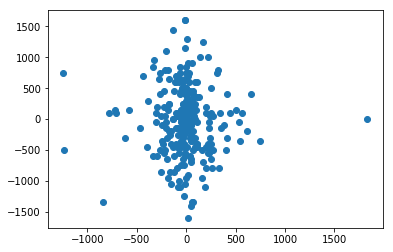

In [142]:
p = plt.scatter(과거비트코인변화, 다음날주가변화)  # 결과 : 크게 관계가 없음.

In [143]:
np.correlate(과거비트코인변화, 다음날주가변화)

array([-1084592.])

In [144]:
np.corrcoef(과거비트코인변화, 다음날주가변화)  # 결과가 0 에 가까우면 상관없음.

array([[ 1.        , -0.02950345],
       [-0.02950345,  1.        ]])

# 입력 X / 출력 Y 분리
- m개의 x, y 쌍 ( m은 샘플 갯수 )
- x(m, 60, 10-15)(국내증시컬럼 + 비트코인컬럼) -> reshape -> (m, 60 * 15)
- y(m, 30, 2) == (m, 30 * 2)

In [145]:
input_seq = 60  #
output_seq = 30
m = len(df) - (input_seq + output_seq) + 1
len(df), m

(258, 169)

In [146]:
# df = df/df.sum() # 그냥 정규화
df = (df - df.min()) / (df.max()-df.min())  # min_max 정규화
x_list = []
y_list = []
for i in range(m):
    x = df.iloc[i:i+input_seq]  # 60일씩
    y = df.iloc[i+input_seq:i+input_seq+output_seq][['종가', 'Close**']]
    #x_list.append(x.values)         
    #y_list.append(y.values)
    x_list.append(x)         
    y_list.append(y)

In [147]:
# 7월 3일 코딩방법 (배열을 쌓음)
x_3d = np.stack(x_list, axis=0)
y_3d = np.stack(y_list, axis=0)
x_3d.shape, y_3d.shape 

((169, 60, 12), (169, 30, 2))

In [148]:
# 7월 2일 코딩 방법
# X = np.array(x_list)
# y = np.array(y_list)
# X.shape, y.shape  
# 2차원으로 변환
# X = np.reshape(X,[m, -1])
# y = np.reshape(y,[m, -1])

In [149]:
korea_close_index = 0
bitcoin_close_index = 9

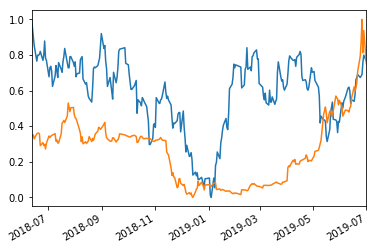

In [150]:
df['종가'].plot()
df['Close**'].plot()

# Train / Test 분리
- test 10%

In [151]:
test_ratio = 0.1
test_m = int(len(x_3d) *  test_ratio)
test_m

16

In [152]:
x_2d = np.reshape(x_3d,[m, -1])
y_2d = np.reshape(y_3d,[m, -1])
x_test = x_2d[:test_m]
x_train = x_2d[test_m:]
y_test = y_2d[:test_m]
y_train = y_2d[test_m:]

In [153]:
x_test.shape, x_train.shape, y_test.shape, y_train.shape

((16, 720), (153, 720), (16, 60), (153, 60))

In [154]:
# 모델 선택, 학습, 가중치를 작게 제약시킨다 > 모든 정보를 활용해서 예측
from sklearn.linear_model import Ridge
model = Ridge(solver='lsqr').fit(x_train, y_train)  # 2차원 이하만 가능 : solver='lsqr' => 절대값을 제곱으로 변경

In [155]:
model.score(x_train, y_train),model.score(x_test, y_test)

(0.992512035988599, -9.00566456781055)

In [156]:
# 가장 최근 데이터
recent = df.iloc[-input_seq:]
recent = np.reshape(np.array(recent), [1,-1])
recent.shape

(1, 720)

In [157]:
p = model.predict(recent)  # 미래예측
p.shape

(1, 60)

In [158]:
p = np.reshape(p,[output_seq, -1])
p.shape

(30, 2)

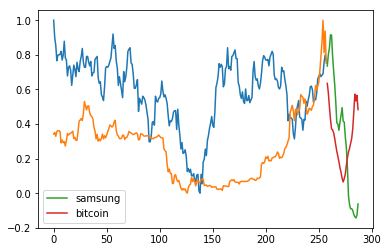

In [160]:
xm = len(df)
plt.plot(np.arange(xm), df['종가'].values)
plt.plot(np.arange(xm), df['Close**'].values)
plt.plot(np.arange(xm,xm+output_seq), p[:,0], label='samsung')
plt.plot(np.arange(xm,xm+output_seq), p[:,1], label='bitcoin')
plt.legend()